In [3]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D 

In [4]:
poses = pd.read_csv('../KITTI_visual_odometry/dataset/poses/00.txt', delimiter=' ', header=None)
print('Shape of position dataframe:', poses.shape)

poses.head()

Shape of position dataframe: (4541, 12)


,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,9.043680e-12,2.326809e-11,5.551115e-17,9.043683e-12,1.000000,2.392370e-10,3.330669e-16,2.326810e-11,2.392370e-10,1.000000,-4.440892e-16
1,0.999998,5.272628e-04,-2.066935e-03,-4.690294e-02,-5.296506e-04,0.999999,-1.154865e-03,-2.839928e-02,2.066324e-03,1.155958e-03,0.999997,8.586941e-01
2,0.999991,1.048972e-03,-4.131348e-03,-9.374345e-02,-1.058514e-03,0.999997,-2.308104e-03,-5.676064e-02,4.128913e-03,2.312456e-03,0.999989,1.716275e+00
3,0.999980,1.566466e-03,-6.198571e-03,-1.406429e-01,-1.587952e-03,0.999993,-3.462706e-03,-8.515762e-02,6.193102e-03,3.472479e-03,0.999975,2.574964e+00
4,0.999964,2.078471e-03,-8.263498e-03,-1.874858e-01,-2.116664e-03,0.999987,-4.615826e-03,-1.135202e-01,8.253797e-03,4.633149e-03,0.999955,3.432648e+00


In [5]:
gt = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    gt[i] = np.array(poses.iloc[i]).reshape((3, 4))

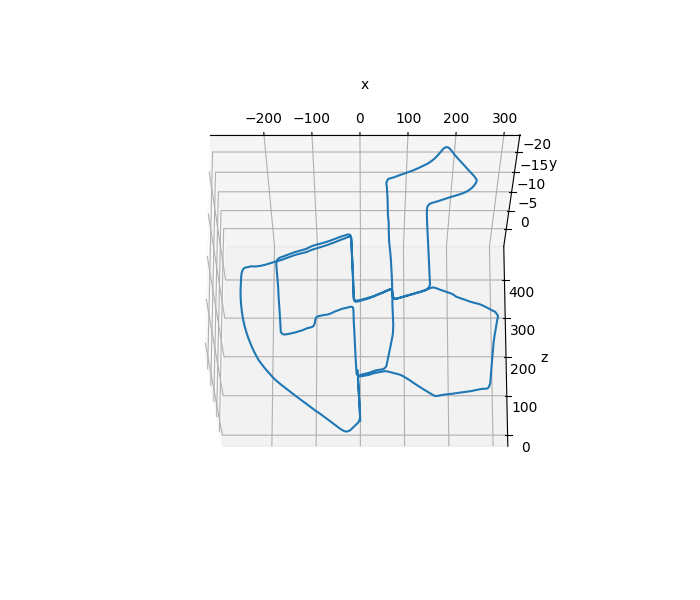

In [6]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(gt[:, :, 3][:, 0], gt[:, :, 3][:, 1], gt[:, :, 3][:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=-20, azim=270)

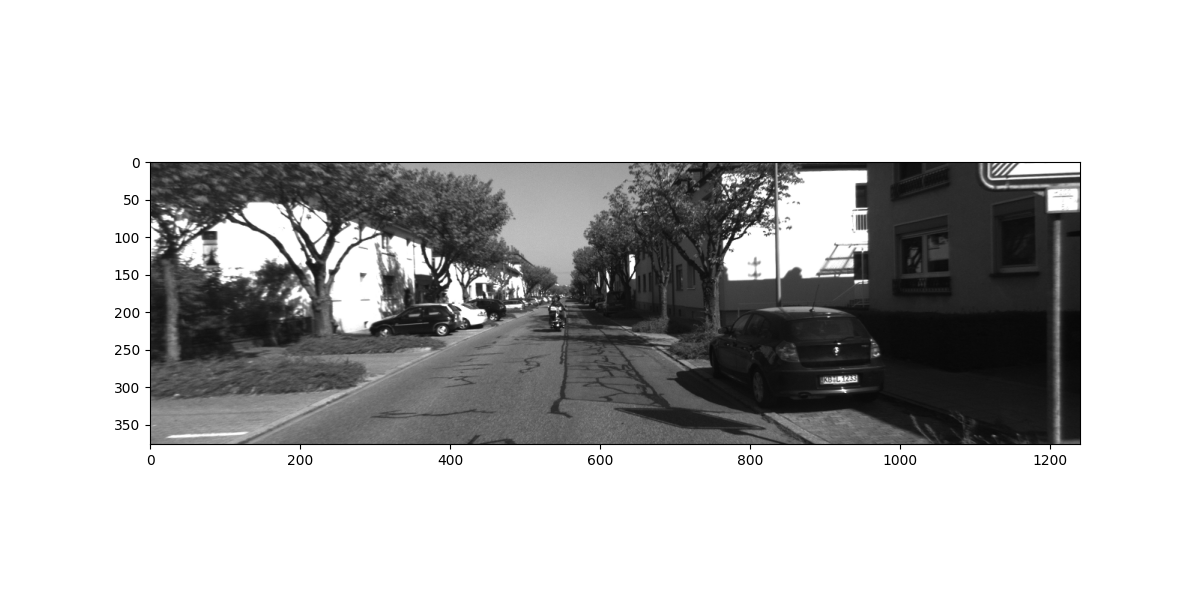

In [7]:
test_img = cv2.imread('../KITTI_visual_odometry/dataset/sequences/00/image_0/000000.png')
plt.figure(figsize=(12,6))
plt.imshow(test_img)

In [8]:
calib = pd.read_csv('../KITTI_visual_odometry/dataset/sequences/00/calib.txt', delimiter=' ', header=None, index_col=0)
calib

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
P0:,718.856000,0.000000,607.192800,0.000000,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P1:,718.856000,0.000000,607.192800,-386.144800,0.000000,718.856000,185.215700,0.000000,0.000000,0.000000,1.000000,0.000000
P2:,718.856000,0.000000,607.192800,45.382250,0.000000,718.856000,185.215700,-0.113089,0.000000,0.000000,1.000000,0.003780
P3:,718.856000,0.000000,607.192800,-337.287700,0.000000,718.856000,185.215700,2.369057,0.000000,0.000000,1.000000,0.004915
Tr:,0.000428,-0.999967,-0.008084,-0.011985,-0.007211,0.008081,-0.999941,-0.054040,0.999974,0.000486,-0.007207,-0.292197


In [9]:
class Dataset_Handler():
    def __init__(self, sequence):
            
    
        # Set file paths and get ground truth poses
        self.seq_dir = '../KITTI_visual_odometry/dataset/sequences/{}/'.format(sequence)
        self.poses_dir = '../KITTI_visual_odometry/dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Get names of files to iterate through
        self.left_image_files = os.listdir(self.seq_dir + 'image_0')
        self.left_image_files= sorted(self.left_image_files)
        self.right_image_files = os.listdir(self.seq_dir + 'image_1')
        self.right_image_files= sorted(self.right_image_files) #####to rectify random sequences###
        self.num_frames = len(self.left_image_files)
        
        # Get calibration details for scene
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
            
        self.reset_frames()
        # Store original frame to memory for testing functions
        self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                            + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                            + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                            + self.left_image_files[1], 0)
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
        
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        pass


In [10]:
handler = Dataset_Handler('00')

In [11]:
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    
  
    sad_window = 6  #tuning.
    num_disparities = sad_window*16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size
                                     )
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 3 * sad_window ** 2,
                                        P2 = 32 * 3 * sad_window ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
                                       )
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}:', end-start)
    
    return disp_left

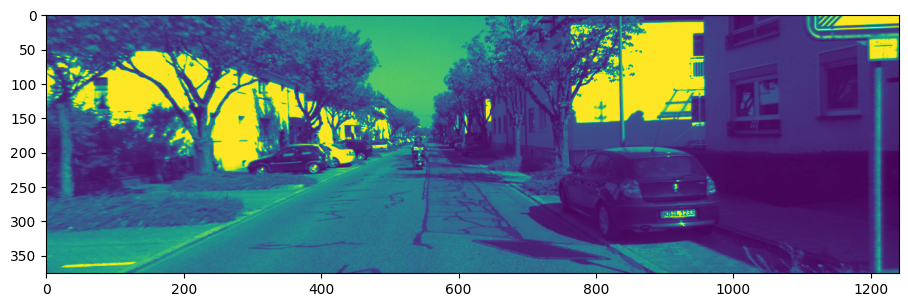

In [10]:
plt.figure(figsize=(11,7))
plt.imshow(handler.first_image_left);

Time to compute disparity map using StereoBM: 0:00:00.020529


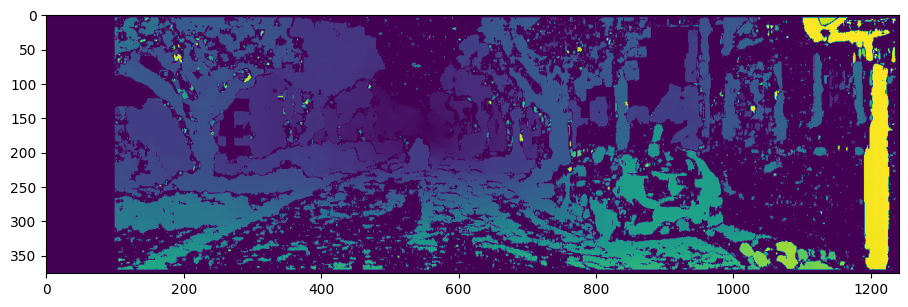

In [11]:
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM: 0:00:00.021592


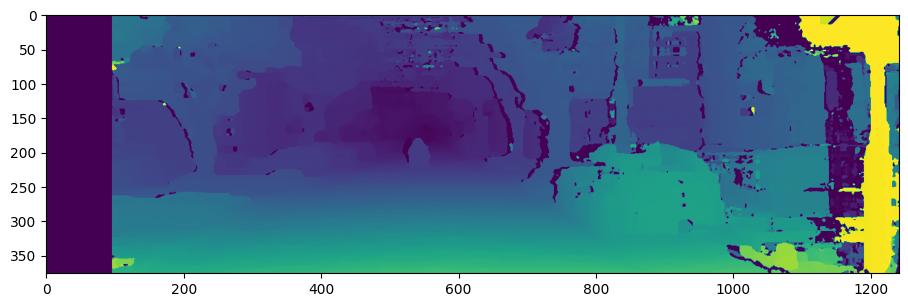

In [12]:
disp = compute_left_disparity_map(handler.first_image_left, 
                                  handler.first_image_right, 
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

In [13]:
def decompose_projection_matrix(p):
   
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [12]:
def calc_depth_map(disp_left, k_left, t_left, t_right):
    
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    
    b = t_right[0] - t_left[0] 
    
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [13]:
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False, 
                   rectified=True):

    # Compute disparity map
    disp = compute_left_disparity_map(img_left, 
                                      img_right, 
                                      matcher=matcher, 
                                      rgb=rgb, 
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

In [15]:
def extract_features(image, detector='sift', mask=None):
  
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
   
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [18]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
   
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [19]:
def filter_matches_distance(matches, dist_threshold):


    filtered_match = []
    matches.print()
    for m, n in matches:
        print("here look:",m.distance, n.distance,dist_threshold*n.distance )
        if m.distance <= dist_threshold*n.distance: 
            filtered_match.append(m)

    return filtered_match

In [20]:
def visualize_matches(image1, kp1, image2, kp2, match):
    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [21]:
def estimate_motion(match, kp1, kp2, k, depth1=None, max_depth=3000):
   
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])
   
    if depth1 is not None:
        cx = k[0, 2]
        cy = k[1, 2]
        fx = k[0, 0]
        fy = k[1, 1]
        object_points = np.zeros((0, 3))
        delete = []

       
        for i, (u, v) in enumerate(image1_points):
            z = depth1[int(v), int(u)]
       
            if z > max_depth:
                delete.append(i)
                continue
                
            # Use arithmetic to extract x and y (faster than using inverse of k)
            x = z*(u-cx)/fx
            y = z*(v-cy)/fy
            object_points = np.vstack([object_points, np.array([x, y, z])])
           
        image1_points = np.delete(image1_points, delete, 0)
        image2_points = np.delete(image2_points, delete, 0)
        
 
        _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
        
        rmat = cv2.Rodrigues(rvec)[0]
    
    else:
        
        image1_points_hom = np.hstack([image1_points, np.ones(len(image1_points)).reshape(-1,1)])
        image2_points_hom = np.hstack([image2_points, np.ones(len(image2_points)).reshape(-1,1)])
        E = cv2.findEssentialMat(image1_points, image2_points, k)[0]
        _, rmat, tvec, mask = cv2.recoverPose(E, image1_points, image2_points, k)
    
    return rmat, tvec, image1_points, image2_points

In [21]:
def visual_odometry(handler, detector='sift', matching='BF', filter_match_distance=None, 
                    stereo_matcher='bm', mask=None, depth_type='stereo', subset=None,
                    plot=False):
    
   
    print('Generating disparities with Stereo{}'.format(str.upper(stereo_matcher)))
    print('Detecting features with {} and matching with {}'.format(str.upper(detector), 
                                                                   matching))
    if filter_match_distance is not None:
        print('Filtering feature matches at threshold of {}*distance'.format(filter_match_distance))

    if subset is not None:
        #subset = subset + 1
        num_frames = subset
    else:
        # Set num_frames to one less than the number of frames so we have sequential images
      
        num_frames = handler.num_frames
        
    if plot:
        fig = plt.figure(figsize=(14, 14))
        ax = fig.add_subplot(projection='3d')
        ax.view_init(elev=-20, azim=270)
        xs = handler.gt[:, 0, 3]
        ys = handler.gt[:, 1, 3]
        zs = handler.gt[:, 2, 3]
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.plot(xs, ys, zs, c='k')
        
    # Establish homogeneous transformation matrix.    
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    imheight = handler.imheight
    imwidth = handler.imwidth
    
    # Decompose 
    k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
    
    if handler.low_memory:
        handler.reset_frames()
        image_plus1 = next(handler.images_left)
    
    
    for i in range(num_frames - 1):
       
        start = datetime.datetime.now()
        
        
        image_left = image_plus1
        image_right = next(handler.images_right)
        
        image_plus1 = next(handler.images_left)
       
       
        if depth_type == 'stereo':
            depth = stereo_2_depth(image_left, 
                                   image_right, 
                                   P0=handler.P0, 
                                   P1=handler.P1,
                                   matcher=stereo_matcher)
       
  
            
        # Get keypoints and descriptors 
        kp0, des0 = extract_features(image_left, detector, mask)
        kp1, des1 = extract_features(image_plus1, detector, mask)
        
        # Get matches between features detected in the two images
        matches_unfilt = match_features(des0, 
                                        des1, 
                                        matching=matching, 
                                        detector=detector, 
                                        sort=True)
        
        # Filter
        if filter_match_distance is not None:
            matches = filter_matches_distance(matches_unfilt, filter_match_distance)
        else:
            matches = matches_unfilt
            
        # Estimate motion 
        rmat, tvec, img1_points, img2_points = estimate_motion(matches, kp0, kp1, k_left, depth)
      
        Tmat = np.eye(4)
        
        Tmat[:3, :3] = rmat
        Tmat[:3, 3] = tvec.T
        
        
        T_tot = T_tot.dot(np.linalg.inv(Tmat))
            
        
        trajectory[i+1, :, :] = T_tot[:3, :]
        
        end = datetime.datetime.now()
        print('Time to compute frame {}:'.format(i+1), end-start)
        
        if plot:
            xs = trajectory[:i+2, 0, 3]
            ys = trajectory[:i+2, 1, 3]
            zs = trajectory[:i+2, 2, 3]
            plt.plot(xs, ys, zs, c='chartreuse')
            plt.pause(1e-32)
            
    if plot:        
        plt.close()
        
    return trajectory

In [22]:

def calculate_error(ground_truth, estimated, error_type='mse'):
    
    
    nframes_est = estimated.shape[0]-1
    
    def get_mse(ground_truth, estimated):
        se = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
        mse = se.mean()
        return mse
    
    def get_mae(ground_truth, estimated):
        ae = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)
        mae = ae.mean()
        return mae
    
    if error_type == 'mae':
        return get_mae(ground_truth, estimated)
    elif error_type == 'mse':
        return get_mse(ground_truth, estimated)
    elif error_type == 'rmse':
        return np.sqrt(get_mse(ground_truth, estimated))
    elif error_type == 'all':
        mae = get_mae(ground_truth, estimated)
        mse = get_mse(ground_truth, estimated)
        rmse = np.sqrt(mse)
        return {'mae': mae,
                'rmse': rmse,
                'mse': mse}

In [23]:
# We can constuct a mask using this information like so
mask = np.zeros(handler.first_image_left.shape[:2], dtype=np.uint8)
ymax = handler.first_image_left.shape[0]
xmax = handler.first_image_left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask);

In [53]:

start = datetime.datetime.now()
trajectory_nolidar_bm = visual_odometry(handler,
                                        filter_match_distance=0.9, 
                                        detector='sift',
                                        stereo_matcher='sgbm',
                                        mask=mask,     
                                        subset=None)
end = datetime.datetime.now()
print('Time to perform odometry:', end-start)


# start = datetime.datetime.now()
# trajectory_nolidar_bm = visual_odometry(handler,
#                                         filter_match_distance=0.6, 
#                                         detector='orb',
#                                         stereo_matcher='sgbm',
#                                         mask=mask,     
#                                         subset=None)
# end = datetime.datetime.now()
# print('Time to perform odometry:', end-start)

Generating disparities with StereoSGBM
Detecting features with ORB and matching with BF
Filtering feature matches at threshold of 0.6*distance
here look: 3.0 28.0 16.8
here look: 4.0 53.0 31.799999999999997
here look: 8.0 32.0 19.2
here look: 9.0 17.0 10.2
here look: 9.0 40.0 24.0
here look: 10.0 33.0 19.8
here look: 11.0 46.0 27.599999999999998
here look: 11.0 48.0 28.799999999999997
here look: 11.0 57.0 34.199999999999996
here look: 12.0 40.0 24.0
here look: 12.0 57.0 34.199999999999996
here look: 12.0 50.0 30.0
here look: 12.0 34.0 20.4
here look: 12.0 32.0 19.2
here look: 13.0 42.0 25.2
here look: 13.0 53.0 31.799999999999997
here look: 13.0 39.0 23.4
here look: 13.0 38.0 22.8
here look: 14.0 39.0 23.4
here look: 14.0 25.0 15.0
here look: 14.0 33.0 19.8
here look: 14.0 35.0 21.0
here look: 14.0 47.0 28.2
here look: 14.0 47.0 28.2
here look: 14.0 40.0 24.0
here look: 14.0 37.0 22.2
here look: 14.0 52.0 31.2
here look: 15.0 33.0 19.8
here look: 15.0 45.0 27.0
here look: 15.0 54.0 32.

KeyboardInterrupt: 

In [24]:
#np.savetxt('trajectory.csv', trajectory_nolidar_bm.reshape(-1, trajectory_nolidar_bm.shape[-1]), delimiter=',')
np.savetxt('trajectory_orb.csv', trajectory_nolidar_bm.reshape(-1, trajectory_nolidar_bm.shape[-1]), delimiter=',')

NameError: name 'trajectory_nolidar_bm' is not defined

In [2]:
# Load the trajectory back from the CSV file
# loaded_trajectory = np.loadtxt('trajectory.csv', delimiter=',')
loaded_trajectory = np.loadtxt('trajectory.csv', delimiter=',')
# Reshape the loaded data back to the original shape if needed
loaded_trajectory = loaded_trajectory.reshape(4541,3,4)


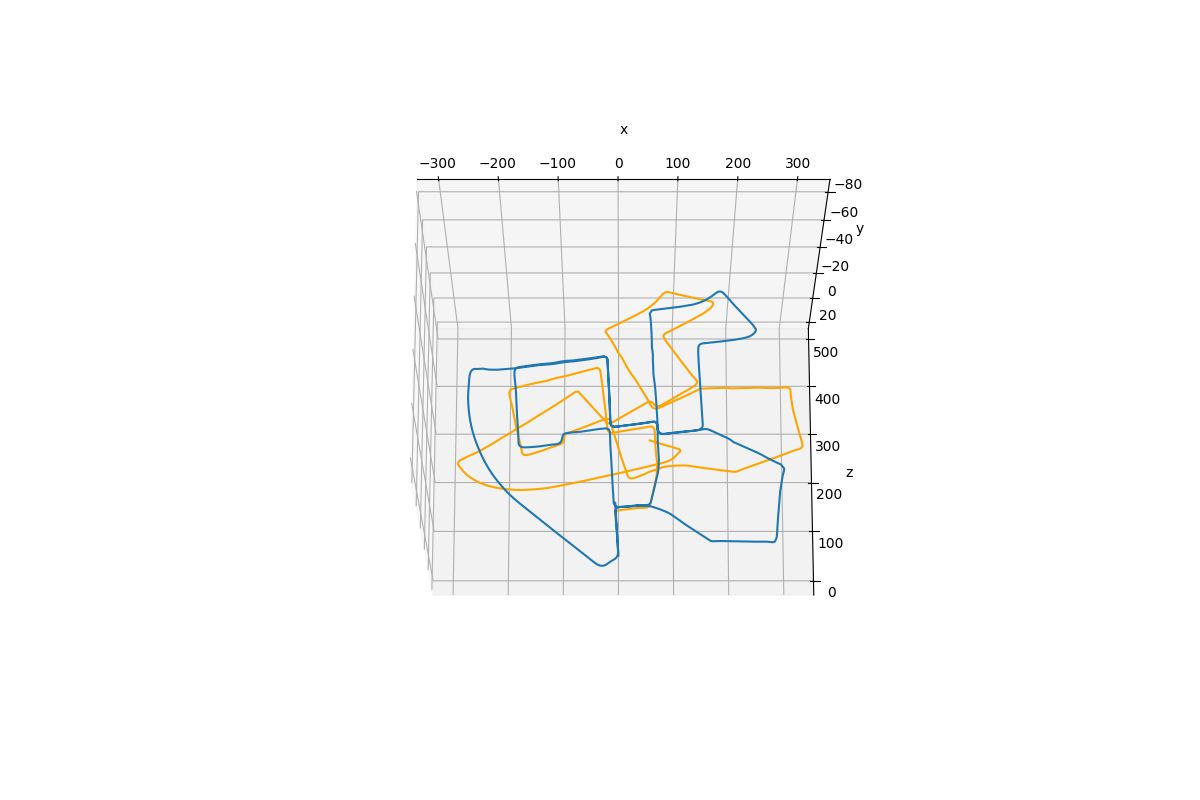

In [6]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(loaded_trajectory[:, :, 3][:, 0], 
        loaded_trajectory[:, :, 3][:, 1], 
        loaded_trajectory[:, :, 3][:, 2], label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        handler.gt[:, :, 3][:, 2], label='ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.view_init(elev=-20, azim=270)

In [9]:
calculate_error(handler.gt, loaded_trajectory, 'all')

{'mae': 210.52681054830478,
 'rmse': 231.5855603823721,
 'mse': 53631.87177761732}

In [ ]:
calculate_error(handler.gt, trajectory_nolidar_sgbm, 'all')

In [43]:
loaded_trajectory[:,:,3][:,1].shape

(4541,)

In [38]:
trajectory_nolidar_bm[:,:,3][:,0]

NameError: name 'trajectory_nolidar_bm' is not defined

In [10]:
from filterpy.kalman import KalmanFilter
import numpy as np

# Create a 2D Kalman filter
kf = KalmanFilter(dim_x=4, dim_z=2)

# Define the state transition matrix (constant velocity model)
kf.F = np.array([[1, 0, 1, 0],
                 [0, 1, 0, 1],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])

# Define the measurement matrix (we directly measure x and y positions)
kf.H = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0]])

# Initialize the state with zero initial position and zero initial velocity


kf.x = np.array([loaded_trajectory[:,:,3][0,0], loaded_trajectory[:,:,3][0,1], 0, 0])


# Define the initial state covariance matrix (larger values indicate more uncertainty)
kf.P = np.eye(4) * 0.9 #initial_covariance  # You can set initial_covariance as needed

# Define process noise and measurement noise covariance matrices
kf.Q = np.array([[0.1, 0, 0, 0],
                 [0, 0.1, 0, 0],
                 [0, 0, 0.1, 0],
                 [0, 0, 0, 0.1]])  # Adjust based on your system
measurement_noise_x=0.3
measurement_noise_y=0.3
kf.R = np.array([[measurement_noise_x, 0],
                 [0, measurement_noise_y]])  # Adjust based on measurement noise

# Initialize an array to store the filtered trajectory
filtered_trajectory = []
filtered_x=[]
filtered_y=[]
# Apply the Kalman filter to each point in the original trajectory
for i in range(len(loaded_trajectory)-1):
    # Predict the next state
    kf.predict()
    
    # Update the state with the current measurement (x, y)
    measurement = np.array([loaded_trajectory[:,:,3][i,0], loaded_trajectory[:,:,3][i,1]])
    kf.update(measurement)
    
    # Get the filtered state estimate
    filtered_state = kf.x
    
    # Append the filtered state to the filtered_trajectory
    filtered_trajectory.append(filtered_state)
    filtered_x.append(filtered_state[0])
    filtered_y.append(filtered_state[1])

# Convert the filtered_trajectory list to a numpy array
filtered_trajectory = np.array(filtered_trajectory)


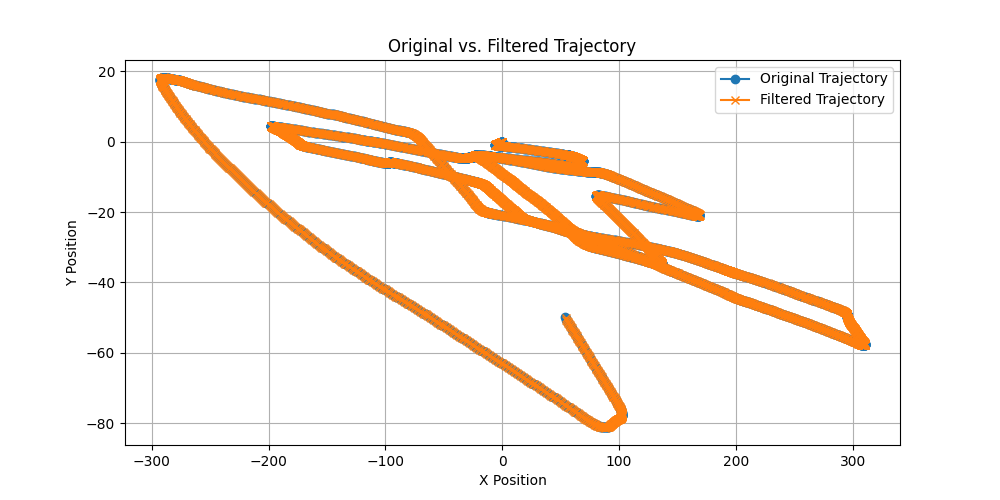

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(loaded_trajectory[:, :, 3][:, 0], loaded_trajectory[:, :, 3][:, 1], label='Original Trajectory', marker='o')
plt.plot(filtered_x, filtered_y, label='Filtered Trajectory', marker='x')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Original vs. Filtered Trajectory')
plt.legend()
plt.grid(True)
plt.show()

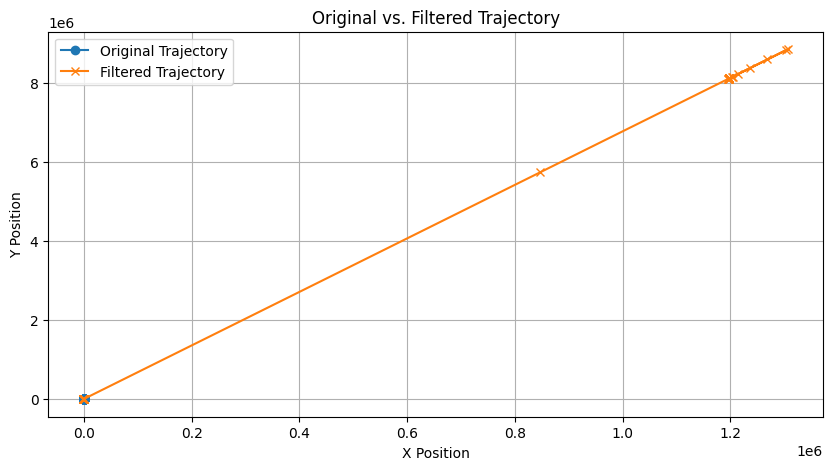

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(handler.gt[:, :, 3][:, 0], handler.gt[:, :, 3][:, 1], label='Original Trajectory', marker='o')
plt.plot(filtered_x, filtered_y, label='Filtered Trajectory', marker='x')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Original vs. Filtered Trajectory')
plt.legend()
plt.grid(True)
plt.show()

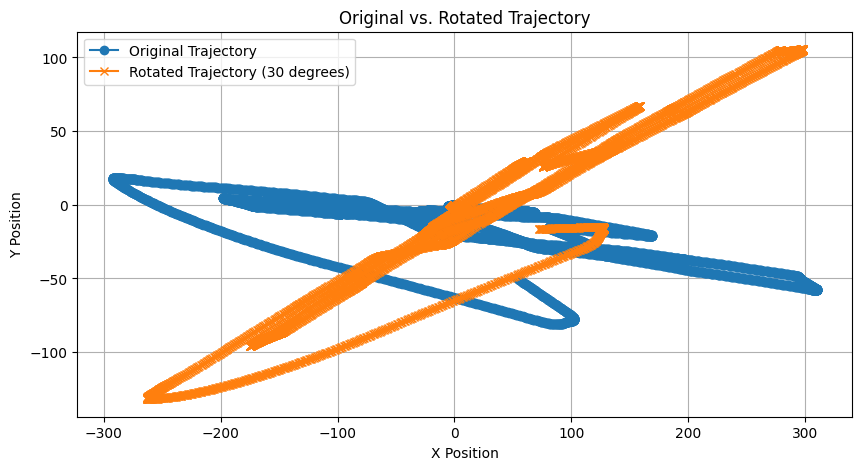

In [39]:
# Define the rotation angle in degrees
rotation_angle = 30  # Modify this angle as needed

# Convert the rotation angle to radians
rotation_angle_rad = np.radians(rotation_angle)

# Create a rotation matrix to rotate points around the origin
rotation_matrix = np.array([[np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad)],
                            [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad)]])

# Rotate the filtered trajectory points
rotated_trajectory = np.dot(rotation_matrix, np.vstack((filtered_x, filtered_y)))

# Unpack the rotated x and y coordinates
rotated_x, rotated_y = rotated_trajectory[0], rotated_trajectory[1]

# Plot the original and rotated trajectories
plt.figure(figsize=(10, 5))
plt.plot(loaded_trajectory[:, :, 3][:, 0], loaded_trajectory[:, :, 3][:, 1], label='Original Trajectory', marker='o')
plt.plot(rotated_x, rotated_y, label=f'Rotated Trajectory ({rotation_angle} degrees)', marker='x')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Original vs. Rotated Trajectory')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
print(filtered_trajectory[:12,0])
print(handler.gt[:,:,3][:12,0])

[ 0.         -0.00164853 -0.00889545 -0.02337369 -0.04107918 -0.05957606
 -0.08131077 -0.10694074 -0.1352198  -0.16543357 -0.19835587 -0.23458505]
[ 5.551115e-17 -4.690294e-02 -9.374345e-02 -1.406429e-01 -1.874858e-01
 -2.343818e-01 -2.812195e-01 -3.281178e-01 -3.749547e-01 -4.218367e-01
 -4.687329e-01 -5.155474e-01]


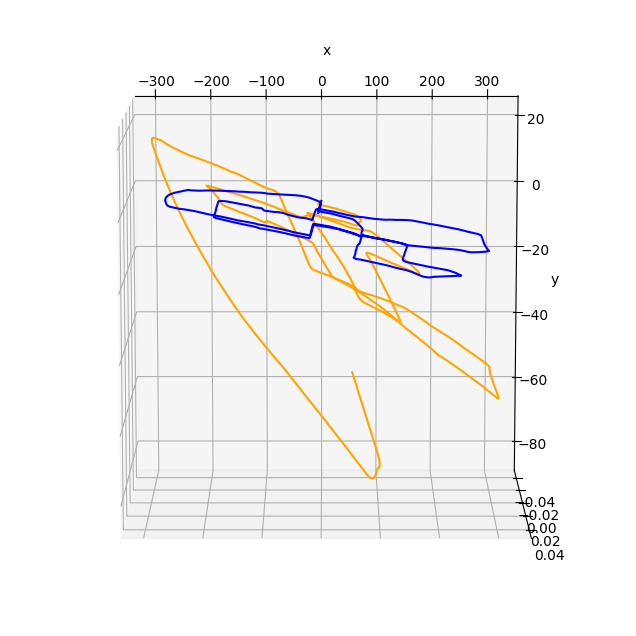

In [33]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(filtered_trajectory[:, 0], 
        filtered_trajectory[:, 1], 
        label='estimated', color='orange')

ax.plot(handler.gt[:, :, 3][:, 0], 
        handler.gt[:, :, 3][:, 1], 
        label='ground truth', color='blue')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.view_init(elev=100, azim=270)

# Add other necessary settings for your plot if needed
plt.show()